In [340]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score,learning_curve, GroupKFold,GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix



In [341]:
df =  pd.read_csv('../2017_07_07/TADPOLE_D1_D2.csv',low_memory=False,header = 0)

In [342]:
#Name of the columns
df.head(0)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Columns: 1907 entries, RID to update_stamp_UPENNBIOMK9_04_19_17
dtypes: float64(72), int64(8), object(1827)
memory usage: 185.4+ MB


In [343]:
#Do some test on the data

print(df['DX'].head(1))
print(df['DX_bl'].unique())
print(df['EXAMDATE_BAIPETNMRC_09_12_16'].head(1))
print(df['PTETHCAT'].head(1))
print(df['ABETA_UPENNBIOMK9_04_19_17'].head(1))

0    NL
Name: DX, dtype: object
['CN' 'AD' 'LMCI' 'EMCI' 'SMC']
0    2005-09-22
Name: EXAMDATE_BAIPETNMRC_09_12_16, dtype: object
0    Not Hisp/Latino
Name: PTETHCAT, dtype: object
0     
Name: ABETA_UPENNBIOMK9_04_19_17, dtype: object


In [344]:
df['DX_bl'].unique()
df['DX'].unique()

array(['NL', 'Dementia', 'MCI', 'NL to MCI', 'MCI to Dementia',
       'MCI to NL', 'Dementia to MCI', nan, 'NL to Dementia'],
      dtype=object)

In [345]:
pd.set_option('display.max_columns', None)

#important columns to convert to int: EXAMDATE	DX_bl	DXCHANGE	AGE	PTGENDER	PTEDUCAT	PTETHCAT	PTRACCAT	PTMARRY	

In [346]:
print(df['DXCHANGE'].head(1))
'1=Stable:NL to NL, 2=Stable:MCI to MCI, 3=Stable:AD to AD, ' 
'4=Conv:NL to MCI, 5=Conv:MCI to AD, 6=Conv:NL to AD, ' 
'7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL, -1=Not available'
# 1 7 9 final NL / 2 4 8 final MCI / 3 5 6 final AD

0    1.0
Name: DXCHANGE, dtype: float64


'7=Rev:MCI to NL, 8=Rev:AD to MCI, 9=Rev:AD to NL, -1=Not available'

In [347]:
data = df
print(data.shape)

#Convert to numeric
data['PTGENDER']= data['PTGENDER'].replace(['Male','Female'],[1,0])
data['APOE4']= data['APOE4'].astype(float)
data['AGE']= data['AGE'].astype(float)
data['PTETHCAT']= data['PTETHCAT'].replace(['Hisp/Latino','Not Hisp/Latino','Unknown'],[2,1,0]).astype(int)
data['PTMARRY']= data['PTMARRY'].replace(['Married','Widowed','Divorced','Never married','Unknown'],[0,1,2,3,4]).astype(int)
data['PTRACCAT'] = data['PTRACCAT'].replace(['White','More than one','Black','Asian', 'Am Indian/Alaskan','Hawaiian/Other PI', 'Unknown'],[0,1,2,3,4,5,6]).astype(int)
data['DX_bl'] = data['DX_bl'].replace(['CN' ,'AD' ,'LMCI' ,'EMCI' ,'SMC'],['0','1','2','3','4']).astype(int)
data['DX'] = data['DX'].replace(['NL' ,'Dementia', 'MCI', 'NL to MCI', 'MCI to Dementia', 'MCI to NL','Dementia to MCI' ,'NL to Dementia'],['1','3','4','5','6','7','8','9'])
#how delete nan from a data['DX'] with pandas
#data['DX'] = np.nan_to_num(data['DX'])
data['DX']=data['DX'].fillna(0)
data['DX'] = data['DX'].astype(int)

data['EXAMDATE_bl'] = pd.to_datetime(data['EXAMDATE_bl']).dt.strftime("%Y%m%d").astype(int)
print(data['EXAMDATE_bl'].head(1))

data['EXAMDATE'] = pd.to_datetime(data['EXAMDATE']).dt.strftime("%Y%m%d").astype(int)
print(data['EXAMDATE'].head(1))
#test = data['DXCHANGE'].replace([1,2,3,4,5,6,7,8,9,-1],[1,2,3,2,3,3,1,2,1,-1]).astype(int)
#test=test.fillna(0)
#data['DXCHANGE_TEST']= test

# 1 7 9 final NL / 2 4 8 final MCI / 3 5 6 final AD
#Print some data to check if it is correct
print(data['DX'].head(1))
print(data['DX'].unique())

# drop the columns in data they ate objet type
data = data.select_dtypes(exclude=['object'])
print(data.shape)


(12741, 1907)
0    20050908
Name: EXAMDATE_bl, dtype: int32
0    20050908
Name: EXAMDATE, dtype: int32
0    1
Name: DX, dtype: int32
[1 3 4 5 6 7 8 0 9]
(12741, 88)


The main measures to be predicted: DX, ADAS13, Ventricles
Cognitive tests: CDRSB, ADAS11, MMSE, RAVLT_immediate
MRI measures: Hippocampus, WholeBrain, Entorhinal, MidTemp
PET measures: FDG, AV45
CSF measures: ABETA_UPENNBIOMK9_04_19_17  (amyloid-beta level in CSF), TAU_UPENNBIOMK9_04_19_17 (tau level), PTAU_UPENNBIOMK9_04_19_17 (phosphorylated tau level)
Risk factors: APOE4, AGE

In [348]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 88 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   RID                       12741 non-null  int64  
 1   SITE                      12741 non-null  int64  
 2   D1                        12741 non-null  int64  
 3   D2                        12741 non-null  int64  
 4   EXAMDATE                  12741 non-null  int32  
 5   DX_bl                     12741 non-null  int32  
 6   DXCHANGE                  8892 non-null   float64
 7   AGE                       12741 non-null  float64
 8   PTGENDER                  12741 non-null  int64  
 9   PTEDUCAT                  12741 non-null  int64  
 10  PTETHCAT                  12741 non-null  int32  
 11  PTRACCAT                  12741 non-null  int32  
 12  PTMARRY                   12741 non-null  int32  
 13  APOE4                     12729 non-null  float64
 14  FDG   

In [349]:
data.drop(['Month'],axis=1)


,RID,SITE,D1,D2,EXAMDATE,DX_bl,DXCHANGE,AGE,PTGENDER,PTEDUCAT,PTETHCAT,PTRACCAT,PTMARRY,APOE4,FDG,PIB,AV45,CDRSB,ADAS11,ADAS13,MMSE,RAVLT_immediate,RAVLT_learning,RAVLT_forgetting,RAVLT_perc_forgetting,FAQ,MOCA,EcogPtMem,EcogPtLang,EcogPtVisspat,EcogPtPlan,EcogPtOrgan,EcogPtDivatt,EcogPtTotal,EcogSPMem,EcogSPLang,EcogSPVisspat,EcogSPPlan,EcogSPOrgan,EcogSPDivatt,EcogSPTotal,Ventricles,Hippocampus,WholeBrain,Entorhinal,Fusiform,MidTemp,ICV,DX,EXAMDATE_bl,CDRSB_bl,ADAS11_bl,ADAS13_bl,MMSE_bl,RAVLT_immediate_bl,RAVLT_learning_bl,RAVLT_forgetting_bl,RAVLT_perc_forgetting_bl,FAQ_bl,Ventricles_bl,Hippocampus_bl,WholeBrain_bl,Entorhinal_bl,Fusiform_bl,MidTemp_bl,ICV_bl,MOCA_bl,EcogPtMem_bl,EcogPtLang_bl,EcogPtVisspat_bl,EcogPtPlan_bl,EcogPtOrgan_bl,EcogPtDivatt_bl,EcogPtTotal_bl,EcogSPMem_bl,EcogSPLang_bl,EcogSPVisspat_bl,EcogSPPlan_bl,EcogSPOrgan_bl,EcogSPDivatt_bl,EcogSPTotal_bl,FDG_bl,PIB_bl,AV45_bl,Years_bl,Month_bl,M
0,2,11,1,1,20050908,0,1.0,74.3,1,16,1,0,0,0.0,1.36926,NaN,NaN,0.0,10.67,18.67,28.0,44.0,4.0,6.0,54.5455,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,1,20050908,0.0,10.67,18.67,28,44.0,4.0,6.0,54.5455,0.0,118233.0,8336.0,1229740.0,4177.0,16559.0,27936.0,1984660.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.36926,NaN,NaN,0.000000,0.00000,0
1,3,11,1,0,20050912,1,3.0,81.3,1,18,1,0,0,1.0,1.09079,NaN,NaN,4.5,22.00,31.00,20.0,22.0,1.0,4.0,100.0000,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,3,20050912,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,NaN,0.000000,0.00000,0
2,3,11,1,0,20060313,1,3.0,81.3,1,18,1,0,0,1.0,1.06360,NaN,NaN,6.0,19.00,30.00,24.0,19.0,2.0,6.0,100.0000,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,88580.0,5446.0,1100060.0,2427.0,14400.0,16972.0,1906430.0,3,20050912,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,NaN,0.498289,5.96721,6
3,3,11,1,0,20060912,1,3.0,81.3,1,18,1,0,0,1.0,1.10384,NaN,NaN,3.5,24.00,35.00,17.0,31.0,2.0,7.0,100.0000,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90099.0,5157.0,1095640.0,1596.0,14617.0,17330.0,1903820.0,3,20050912,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,NaN,0.999316,11.96720,12
4,3,11,1,0,20070912,1,3.0,81.3,1,18,1,0,0,1.0,1.03871,NaN,NaN,8.0,25.67,37.67,19.0,23.0,1.0,5.0,100.0000,14.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97420.0,5139.0,1088560.0,1175.0,14033.0,16398.0,1903420.0,3,20050912,4.5,22.00,31.00,20,22.0,1.0,4.0,100.0000,10.0,84599.0,5319.0,1129830.0,1791.0,15506.0,18422.0,1920690.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09079,NaN,NaN,1.998630,23.93440,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12736,4167,116,1,1,20161116,2,NaN,69.5,0,16,1,0,0,1.0,NaN,NaN,NaN,NaN,37.00,NaN,11.0,NaN,NaN,NaN,NaN,15.0,NaN,2.28571,1.22222,1.00000,1.0,NaN,1.33333,1.38710,4.000,3.88889,3.71429,3.8,3.83333,3.5,3.82051,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,20110825,3.0,18.00,27.00,28,24.0,2.0,6.0,100.0000,11.0,38088.0,5771.0,1000110.0,2934.0,18620.0,19634.0,1496670.0,16.0,2.28571,1.12500,1.71429,1.2,1.66667,2.50,1.70270,2.750,1.22222,1.33333,1.6,NaN,2.25,1.82857,0.93352,NaN,1.539460,5.229290,62.62300,60
12737,4199,116,1,1,20161212,3,NaN,59.0,1,

In [350]:

data.drop(data.iloc[:, 49:88], inplace=True, axis=1)
data.shape

(12741, 49)

In [339]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12741 entries, 0 to 12740
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   RID                    12741 non-null  int64  
 1   SITE                   12741 non-null  int64  
 2   D1                     12741 non-null  int64  
 3   D2                     12741 non-null  int64  
 4   EXAMDATE               12741 non-null  int32  
 5   DX_bl                  12741 non-null  int32  
 6   DXCHANGE               8892 non-null   float64
 7   AGE                    12741 non-null  float64
 8   PTGENDER               12741 non-null  int64  
 9   PTEDUCAT               12741 non-null  int64  
 10  PTETHCAT               12741 non-null  int32  
 11  PTRACCAT               12741 non-null  int32  
 12  PTMARRY                12741 non-null  int32  
 13  APOE4                  12729 non-null  float64
 14  FDG                    3352 non-null   float64
 15  PI

In [252]:
# Algorithme des k plus proches voisins
model = KNeighborsClassifier()
y = data['DXCHANGE']
Y = data['DX_bl']
w = data['DX']

X = data.drop('DXCHANGE', axis=1)
X = data.drop('DX', axis=1)
X = data.drop('DX_bl', axis=1)

#delete bl
y = np.nan_to_num(y)
X= np.nan_to_num(X)
Y = np.nan_to_num(Y)

In [253]:

#Split the data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=5)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=5)

model.fit(X_train,y_train)
print(model.score(X_train,y_train))
print(model.score(X_test,y_test))

model.fit(X_train,Y_train)
print(model.score(X_train,Y_train))
print(model.score(X_test,Y_test))

0.6994592708878423
0.556078431372549
0.7110587824873539
0.552156862745098


In [254]:
#Take the best parameters for the model
param_grid = {'n_neighbors': np.arange(1, 25),'metric': ['euclidean', 'manhattan']}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, y_train)
#values count 


C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])})

In [255]:

grid2 = grid
grid2.fit(X_train, Y_train)

KeyboardInterrupt: 

In [ ]:
# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)
print(grid.best_estimator_)

print(model.score(X_train,y_train))
print(model.score(X_test,y_test))


{'metric': 'manhattan', 'n_neighbors': 6}
0.5861683581926116
KNeighborsClassifier(metric='manhattan', n_neighbors=6)
0.485435199720914
0.39215686274509803


In [ ]:
# Print the tuned parameters and score of the current diagnostic
print(grid2.best_params_)
print(grid2.best_score_)
print(grid2.best_estimator_)

model2 = grid2.best_estimator_
print(model2.score(X_train,Y_train))
print(model2.score(X_test,Y_test))

{'metric': 'manhattan', 'n_neighbors': 6}
0.5861683581926116
KNeighborsClassifier(metric='manhattan', n_neighbors=6)
0.7196057910343625
0.6039215686274509


In [ ]:
#View the error of the model
confusion_matrix(y_test, model.predict(X_test))


array([[307,  29,   0,   8,  47,   0,   0,   0,   0],
       [ 39, 135,   0,  29,  65,   0,   0,   0,   0],
       [ 54,  76,   0,  55, 209,   0,   1,   1,   0],
       [ 23,  39,   0,  53,  46,   0,   2,   0,   0],
       [  1,   3,   0,   0,   5,   0,   0,   0,   0],
       [  2,   6,   0,   8,  23,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  2,   3,   0,   0,   2,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

In [ ]:

confusion_matrix(Y_test, model2.predict(X_test))


array([[323,  25,   3,  39,   0,   0,   0,   0,   0],
       [ 29, 151,  20,  68,   0,   0,   0,   0,   0],
       [ 19,  35,  58,  50,   0,   1,   0,   0,   0],
       [ 43,  74,  40, 238,   0,   2,   0,   0,   0],
       [  2,   4,   0,   3,   0,   0,   0,   0,   0],
       [  1,   8,  12,  18,   0,   0,   0,   0,   0],
       [  2,   3,   0,   2,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0,   0]], dtype=int64)

In [ ]:
#the learning curve
N, train_score,val_score = learning_curve(model,X_train,y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


In [ ]:
#the learning curve
N2, train_score2,val_score2 = learning_curve(model2,X_train,Y_train,train_sizes = np.linspace(0.2,1.0,5),cv=5)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


[1834 3668 5503 7337 9172]


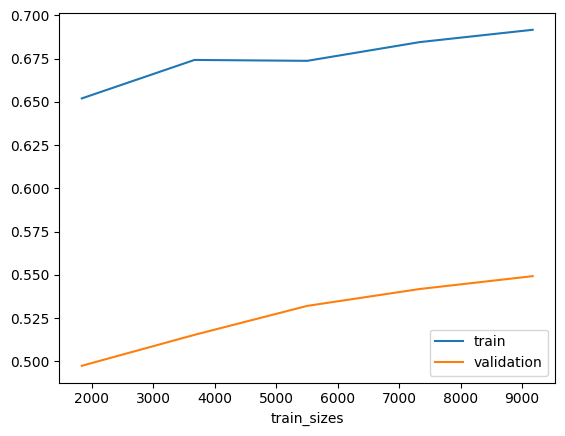

In [ ]:
#Plot the learning curve
print(N)
plt.plot(N,train_score.mean(axis=1), label='train')
plt.plot(N,val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()


[1834 3668 5503 7337 9172]


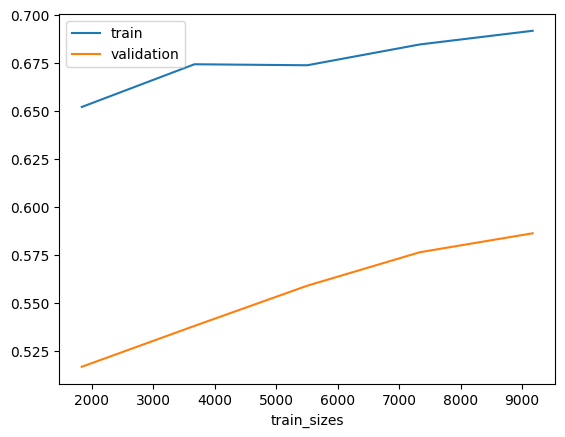

In [ ]:
#Plot the learning curve
print(N2)
plt.plot(N2,train_score.mean(axis=1), label='train')
plt.plot(N2,val_score2.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

In [ ]:
#Chose the best split for the data
cv =  GroupKFold(5).get_n_splits(X,y,groups=X[:,5])
cross_val_score(model,X,y,cv=cv)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


array([0.32757944, 0.43877551, 0.32339089, 0.45251177, 0.30651491])

In [ ]:
cv= StratifiedKFold(5)
cross_val_score(model,X,y,cv=cv)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


array([0.32757944, 0.43877551, 0.32339089, 0.45251177, 0.30651491])

In [ ]:
cv2= StratifiedKFold(5)
cross_val_score(model2,X,Y,cv=cv2)

C:\Users\antoi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(


array([0.32718713, 0.52747253, 0.4022763 , 0.43485086, 0.35949765])